# Code for model training & test

# lib & load_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### installation ###

!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-j7jwokqh
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-j7jwokqh
  Created wheel for py-hanspell: filename=py_hanspell-1.1-cp36-none-any.whl size=4854 sha256=df1a56814ab13131fdd8037687d66c55236122f2133090e8c4b68add4c9c994b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z_fzl4cd/wheels/0a/25/d1/e5e96476dbb1c318cc26c992dd493394fe42b0c204b3e65588
Successfully built py-hanspell


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import reuters
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt, Kkma
okt = Okt()
kkma = Kkma()
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from hanspell import spell_checker

## path setting

In [ ]:
train_data_path = "/content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/data/train_data.csv"
test_data_path = "/content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/data/test_data.csv"

word_to_index_save_path = "/content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/data/"

model_save_path = '/content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/model/best_model.h5'


# Preprocessing

In [ ]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

## 정규 표현식으로 치환
분, 주문번호 변환

In [ ]:
# 정규표현식 함수 정의

def re_sub(df):
    convert_ls =[]
    for idx in (df['text']):
        sample = idx = re.sub(r',', '', idx)
        idx = re.sub(r'(.)(\d)\s(\d)\s(\d)\s(\d)', r'\1\2\3\4\5', sample)
        idx = re.sub("\d\d\d\d"," @",idx)
        idx = re.sub("\d\d분"," #분",idx)
        
        ## 띄어쓰기, 맞춤법
        spelled_sent = spell_checker.check(idx)
        hanspell_sent = spelled_sent.checked
        
        convert_ls.append(hanspell_sent)

    convert_txt = pd.Series(convert_ls, name = 'convert_ls')
    df = pd.concat([df,convert_txt],axis = 1)

    return df

In [ ]:
df_train = re_sub(df_train)
df_test = re_sub(df_test)

In [ ]:
display(df_train)

,Unnamed: 0,text,intent,label,convert_ls
0,352,뒷자리 746,영수증번호,4,뒷자리 746
1,370,30분 뒤 도착,소요시간선택,5,#분 뒤 도착
2,305,가게 도착,가게도착,2,가게 도착
3,90,음식점에 왔어,가게도착,2,음식점에 왔어
4,350,주문 번호 7614,영수증번호,4,주문 번호 @
...,...,...,...,...,...
512,129,주문번호 9972,영수증번호,4,주문번호 @
513,144,뒷자리 4334,영수증번호,4,뒷자리 @
514,72,식당도착했어,가게도착,2,식당 도착했어
515,235,배달 완료 했어,배달완료,6,배달 완료했어


### train_data label 확인

In [ ]:
# label
pd.Series.unique(df_train['intent'])

array(['영수증번호', '소요시간선택', '가게도착', '운행시작', '배달완료', '픽업완료', '가게전화', '소요시간'],
      dtype=object)

## 형태소로 분리 , df에 열로 추가

### tokenizer 테스트

In [ ]:
# okt_ls = []
# for i in range(len(text_data)):
#     okt_text = okt.pos(text_data['convert_ls'][i])
#     okt_ls = okt_ls + okt_text

# pd.unique(okt_ls)

In [ ]:
# kkma_ls = []
# for i in range(len(text_data)):
#     kkma_text = kkma.pos(text_data['convert_ls'][i])
#     kkma_ls = kkma_ls + kkma_text

# pd.unique(kkma_ls)

### kkma가 더 적합해보임

토큰화 / 불용어 제거 / token_len_max

In [ ]:
# kkma 토큰화 함수정의

def kkma_tokenizer(input_df):
    
    valid_pos = ['NNG','VV','SW','MAG']
    
    input_df['token_text'] = np.nan

    for i in range(len(input_df)):
        
        # tokenize
        token_text = kkma.pos(input_df['convert_ls'][i])
        
        # 불용어 제거
        ls = []
        for token in token_text:
            if token[1] in valid_pos:
                ls.append(token[0])
            
            input_df['token_text'][i] = ls

In [ ]:
kkma_tokenizer(df_train)
kkma_tokenizer(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Interer encode

In [ ]:
# save & load word_to_index

import pickle

def save_obj(obj, name ):
    with open(word_to_index_save_path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
# 토크나이저 최적화
from collections import Counter

token_ls = []
vocab = Counter()

for i in range(len(df_train)):
    
    token_ls = token_ls + df_train['token_text'][i]

token_ls = pd.Series(token_ls, name = 'token')

result = []

# 형태소 개수 count: vocab
for word in token_ls:
    result.append(word) 
    vocab[word] = vocab[word]+1 # 각 단어의 빈도를 Count한다

# vocab안에서 정렬
vocab_sorted = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
vocab_sorted

# word to_index 만들기
word_to_index = {}
i = 0
for (word, frequency) in vocab_sorted:
    if frequency > 1: # 빈도수가 적은 단어는 제외
        i += 1
        word_to_index[word] = i


# 글자 묶음 크기
vocab_size = len(word_to_index)+1

# word to index 저장
save_obj(word_to_index, 'word_to_index')

In [ ]:
## df의 정수인코딩 column 생성 및 반영 함수화

def int_encode(df):
    tokenizer = Tokenizer()
    tokenizer.word_index = word_to_index

    df['integer_encode'] = np.nan
    
    for i in range(len(df)):
        
        # integer encode
        seq = tokenizer.texts_to_sequences(df['token_text'])

        df['integer_encode'] = seq

In [ ]:
int_encode(df_train)
int_encode(df_test)

In [ ]:
df_train.to_excel('./df_train_sample.xlsx')

## Padding

In [ ]:
df_train_for_padded = df_train[['integer_encode','label']]
df_test_for_padded = df_test[['integer_encode','label']]

In [ ]:
max_len = 8

train_padded = pad_sequences(df_train_for_padded['integer_encode'], maxlen=max_len)
test_padded = pad_sequences(df_test_for_padded['integer_encode'], maxlen=max_len)

# train_test_split

In [ ]:
x_data_train,x_data_valid, y_data_train, y_data_valid = \
train_test_split(train_padded,
                 df_train['label'],
                 test_size=0.3,
                 random_state=0,
                 shuffle = True)

# Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

## label one_hot_encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

y_data_train_one_hot = to_categorical(y_data_train) # 훈련용 레이블의 원-핫 인코딩
y_data_valid_one_hot = to_categorical(y_data_valid) # valid용 레이블의 원-핫 인코딩

##call_back

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(model_save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

## modeling

In [ ]:
intent = pd.unique(df_train['label'])
print(intent)
intent_count = intent.shape[0]
intent_count

[4 5 2 0 6 3 1]


7

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 120))
model.add(LSTM(120))
model.add(Dense(intent_count, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Epoch 1/20
12/19 [=================>............] - ETA: 0s - loss: 1.9101 - acc: 0.2042
Epoch 00001: val_acc improved from -inf to 0.37179, saving model to /content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/model/best_model.h5
19/19 [==============================] - 2s 88ms/step - loss: 1.8719 - acc: 0.2798 - val_loss: 1.7403 - val_acc: 0.3718
Epoch 2/20
12/19 [=================>............] - ETA: 0s - loss: 1.6852 - acc: 0.4625
Epoch 00002: val_acc improved from 0.37179 to 0.62179, saving model to /content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery_riders)/Chatbot/model/best_model.h5
19/19 [==============================] - 0s 8ms/step - loss: 1.6639 - acc: 0.4931 - val_loss: 1.4646 - val_acc: 0.6218
Epoch 3/20
12/19 [=================>............] - ETA: 0s - loss: 1.3718 - acc: 0.6667
Epoch 00003: val_acc improved from 0.62179 to 0.71795, saving model to /content/drive/MyDrive/Project/Hel_ri_celus (AI voice_bot for delivery

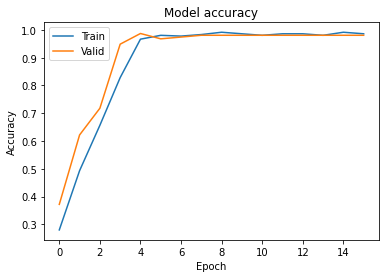

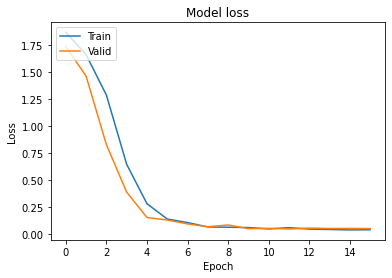

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        37
           3       1.00      0.88      0.94        17
           4       0.92      1.00      0.96        34
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        10

    accuracy                           0.98       156
   macro avg       0.99      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156



In [ ]:
history = model.fit(x_data_train,
                    y_data_train_one_hot,
                    batch_size = 20,
                    epochs=20,
                    callbacks=[es, mc],
                    
                    validation_data=(x_data_valid,
                                     y_data_valid_one_hot))


# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

import sklearn
y_val_series = pd.Series(y_data_valid)
print(sklearn.metrics.classification_report(y_val_series,pred(x_data_valid)))

# predict

In [ ]:
def pred(self):
    
    pred = model.predict(self)
    
    pred_result =[]
    for i in pred:
       
        if np.max(i) < 0.3:
            label = 99
        else:
            label = np.argmax(i)
        
        pred_result.append(label)

    return pred_result

In [ ]:
import sklearn
print(sklearn.metrics.classification_report(df_test['label'],pred(test_padded)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        25
           2       1.00      0.95      0.98        21
           3       0.93      1.00      0.96        13
           4       0.93      1.00      0.97        28
           5       1.00      0.67      0.80         9
           6       1.00      0.82      0.90        11
          99       0.00      0.00      0.00         0

    accuracy                           0.95       130
   macro avg       0.86      0.80      0.83       130
weighted avg       0.98      0.95      0.96       130



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
